In [6]:
import pandas as pd
from glob import glob
import seaborn as sns
import numpy as np
from prediction.functions import new_r2

## Selected Features

## Aggregate prediction results

In [39]:
PREDICTION_MODEL = ['lasso', 'ridge']
FS_METHODS = ['all', 'granger', 'huang', 'IAMB', 'mda', 'mdi', 'MMMB', 'sfi']
EVALUATION_START = '2012-07-03'

In [43]:
predictions = []
r2s = []

for model in PREDICTION_MODEL:
    for fs in FS_METHODS:
        assets = glob('results/forecast/' + fs + '/indices/' + model + '/*.csv')
        for asset_path in assets:
            df = pd.read_csv(asset_path)

            r2_eval_df = df.copy()
            r2_eval_df.set_index('date', inplace=True)
            r2_eval_df = r2_eval_df.loc[EVALUATION_START:]
            r2 = new_r2(r2_eval_df['return'].values, r2_eval_df['prediction'].values)
            r2_df = pd.DataFrame([{'model': model,
                                'fs': fs,
                                'r2': r2}])
            r2s.append(r2_df)

            melt_df = df.melt('date')
            melt_df['model'] = model
            melt_df['fs'] = fs
            predictions.append(melt_df)

predictions_df = pd.concat(predictions, axis=0)
r2_df = pd.concat(r2s, axis=0)

## R2 -  Gu, Kelly, and Xiu (2020)

In [44]:
r2_df.pivot_table(index=['fs'], columns=['model'], values=['r2'])

r2          
model       lasso     ridge
fs                         
IAMB     0.002607 -0.031989
MMMB     0.002607 -0.024441
all      0.002607 -8.889881
granger  0.002607 -0.048806
huang    0.001619  0.001242
mda      0.002607 -0.667920
mdi      0.002607 -1.153038
sfi      0.002607 -4.695204

## Return Plots

In [27]:
lasso_df = predictions_df.loc[predictions_df['model'] == 'lasso']
lasso_df = pd.concat([lasso_df.loc[(lasso_df['variable'] == 'return')&(lasso_df['fs'] == 'all')], lasso_df.loc[lasso_df['variable'] == 'prediction']], axis=0)

<AxesSubplot:xlabel='date'>

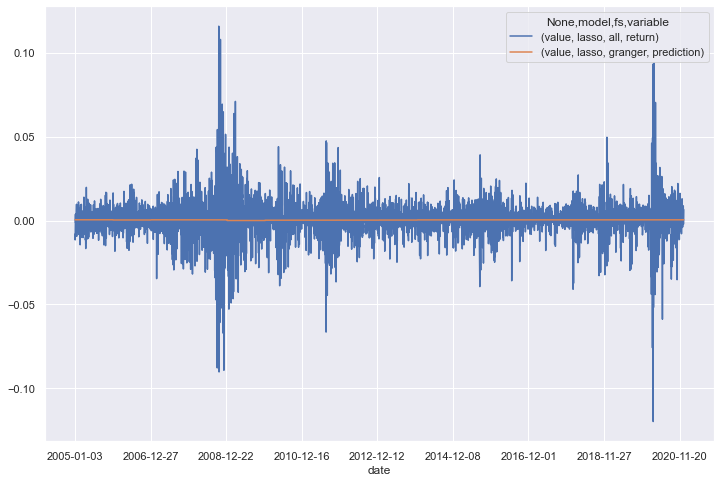

In [77]:
lasso_df.loc[((lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'granger'))|(lasso_df['variable'] == 'return')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

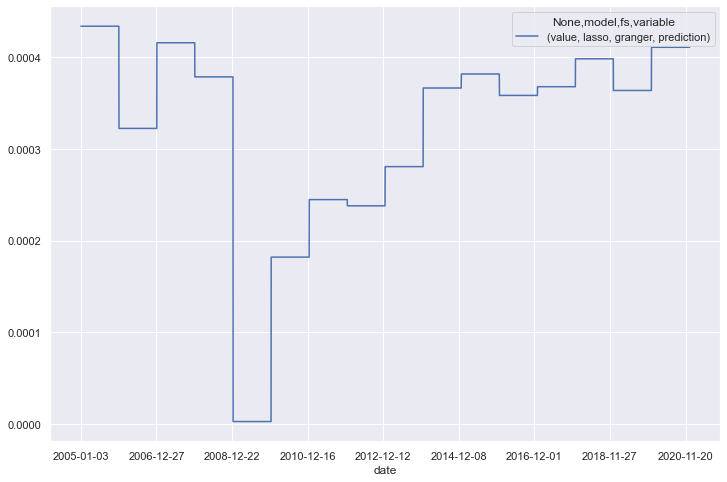

In [68]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'granger')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

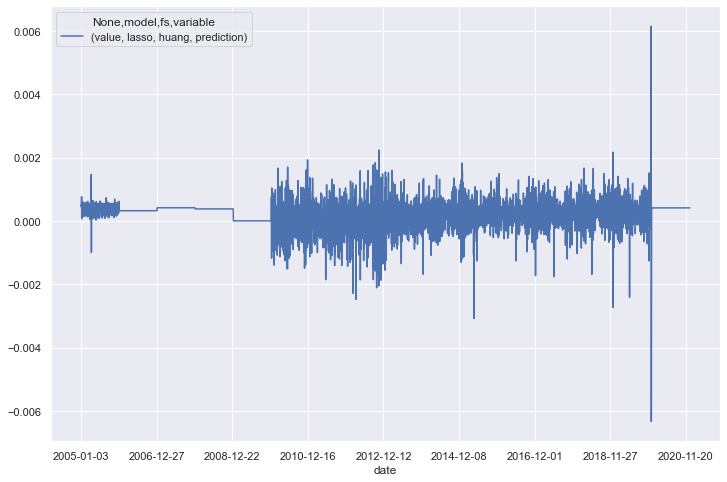

In [78]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'huang')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

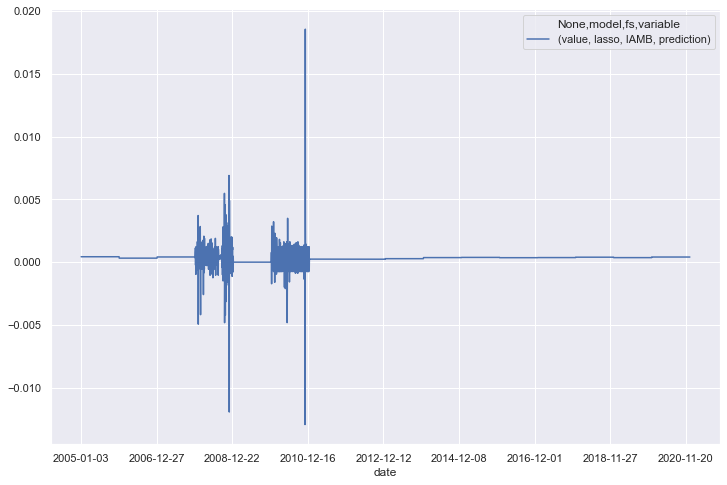

In [79]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'IAMB')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

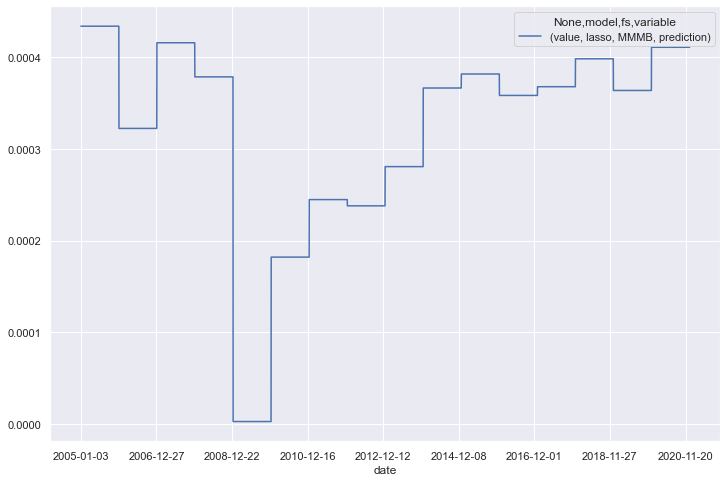

In [80]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'MMMB')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

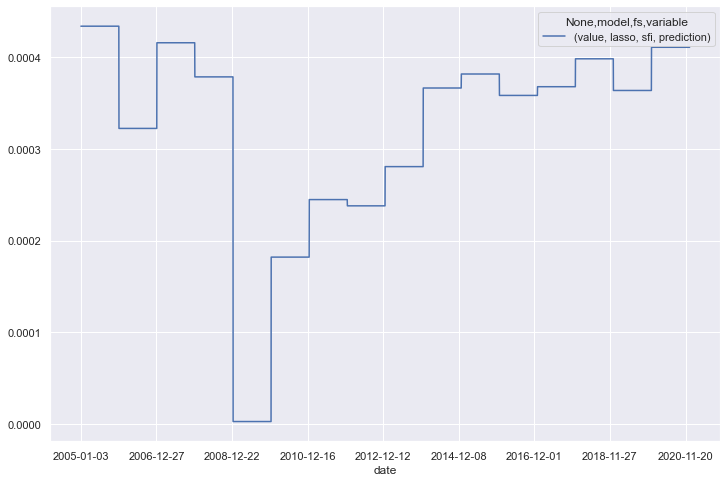

In [81]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'sfi')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

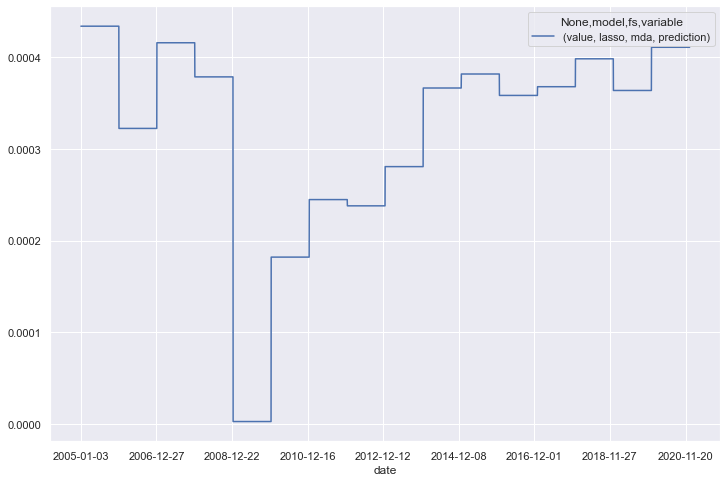

In [82]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'mda')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))

<AxesSubplot:xlabel='date'>

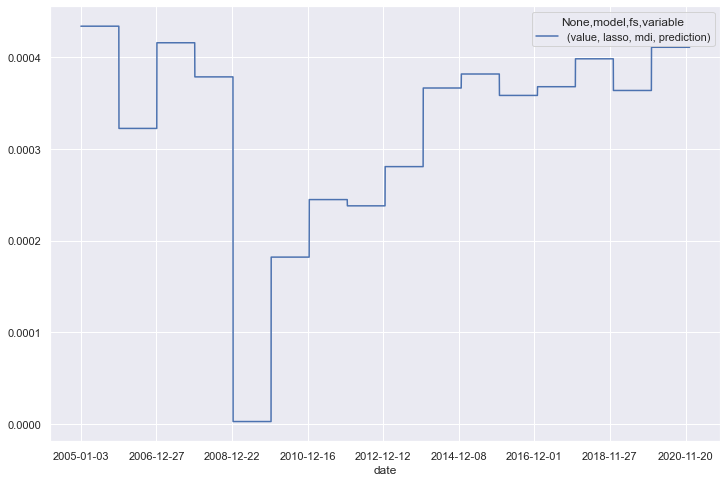

In [83]:
lasso_df.loc[(lasso_df['variable'] == 'prediction')&(lasso_df['fs'] == 'mdi')].pivot_table(index=['date'], columns=['model', 'fs', 'variable'], values=['value']).plot(figsize=(12, 8))